# COMP 551 - Mini Project 3 (Group 60)
**In this miniproject, you will implement a multilayer perceptron from scratch, and use it to classify image data. The goal is to implement a basic neural network and its training algorithm from scratch and get hands-on experience with important decisions that you have to make while training these models.**

In [ ]:
import numpy as np
import string
import pandas as pd # use Pandas to preprocess the data

# tensorflow
import tensorflow as tf

# the output of plotting commands is displayed inline within frontends
%matplotlib inline                                  
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace # for debugging

import random

# set the seed for reproducibility
np.random.seed(1234)

## Task 1: Acquire the data
Your ﬁrst task is to acquire the image dataset. You will be using only one dataset in your experiments: MNIST. Use the MNIST dataset with the default train and test partitions.
Since you will be working with multilayer perceptrons, after loading the data, you will have to vectorize it so that it can have the appropriate dimensions.

11493376/11490434 [==============================] - 0s 0us/step
Each image is 28x28 pixels
Number of training data: 60000
Number of testing data: 10000

Example data:  5


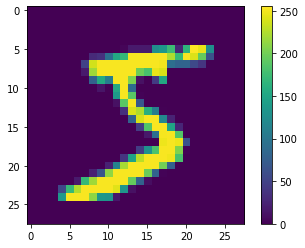


Training data shape: (60000, 784)
Testing data shape: (10000, 784)


In [ ]:
# load data using tensorflow
(MNIST_x_train, MNIST_y_train), (MNIST_x_test, MNIST_y_test) = tf.keras.datasets.mnist.load_data()
print("Each image is {}x{} pixels".format(int(MNIST_x_train.shape[1]), int(MNIST_x_train.shape[2])))
print("Number of training data:", len(MNIST_x_train))
print("Number of testing data:", len(MNIST_x_test))
print()
MNIST_y_train_original = MNIST_y_train

# Convert train y from N to (N x C) 
new_y = np.zeros((MNIST_y_train.shape[0], np.max(MNIST_y_train)+1))
for i in range(MNIST_y_train.shape[0]):
    new_y[i][MNIST_y_train[i]] = 1
MNIST_y_train = new_y

# data example:
print("Example data: ", MNIST_y_train_original[0])
plt.imshow(MNIST_x_train[0, :, :])
plt.colorbar()
plt.show()
print()

# vectorize data to 2D: # of data x image pixels
MNIST_x_train_vec_unnormalized = MNIST_x_train.reshape(MNIST_x_train.shape[0], MNIST_x_train.shape[1] * MNIST_x_train.shape[2]).astype('float64')
MNIST_x_test_vec_unnormalized = MNIST_x_test.reshape(MNIST_x_test.shape[0], MNIST_x_test.shape[1] * MNIST_x_test.shape[2]).astype('float64')
print("Training data shape:", MNIST_x_train_vec_unnormalized.shape)
print("Testing data shape:", MNIST_x_test_vec_unnormalized.shape)

MNIST_x_train_vec = np.copy(MNIST_x_train_vec_unnormalized)
MNIST_x_test_vec = np.copy(MNIST_x_test_vec_unnormalized)

# Noramalization: mean subtraction and normalize by standard deviation
MNIST_x_train_vec -= np.mean(MNIST_x_train_vec_unnormalized)
MNIST_x_test_vec -= np.mean(MNIST_x_test_vec_unnormalized)

MNIST_x_train_vec /= np.std(MNIST_x_train_vec)
MNIST_x_test_vec /= np.std(MNIST_x_test_vec)

## Task 2: Implement a Multilayer Perceptron
In this mini-project, you will implement a multilayer perceptron (MLP) to classify image data. Your implementation should include the backpropagation and the mini-batch gradient descent algorithm (e.g. SGD).

Regarding the implementation, we recommend the following approach:
- Implement the MLP as a python class. The constructor for the class should take as input the activation function (e.g. ReLU), the number of hidden layers (e.g. 2) and the number of units in the hidden layers (e.g. [64; 64]) and it should initialize the weights and biases (with an initializer of your choice) as well as other important properties of the MLP.
- The class should have (at least) two functions:
  - A fit function, which takes the training data (i.e. X and y) - as well as other hyperparameters (e.g. the learning rate and number of gradient descent iterations) - as input. This function should train your model by modifying the model parameters.
  - A predict function, which takes a set of input points (i.e. X) as input and outputs predictions (i.e. yh) for these points.
- In addition to the model classes, you should also define a function evaluate acc to evaluate the model accuracy. This function should take the true labels (i.e. y), and target labels (i.e. yh) as input, and it should output the accuracy score.

**Evaluate accuracy function:**

In [ ]:
# this function will take the true labels (i.e. ground truth), and target labels (i.e. predictions) as input, and output the accuracy score
def evaluate_acc(trueLabel, targetLabel):
    accuracy = np.sum(targetLabel == trueLabel)/trueLabel.shape[0] # calculate the accuracy
    return accuracy

In [ ]:
def logistic(z, derivative=False):
    if(derivative == True):
        f = 1./ (1 + np.exp(-z))
        return f * (1-f)
    else:
        return 1./ (1 + np.exp(-z))

def relu(z, derivative=False):
    if(derivative == True):
        return 1. * (z > 0)
    else:
        return np.maximum(z, 0.0) 

def tanh(z, derivative=False):
    if(derivative == True):
        return 1-(np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))**2
    else:
        return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

from sklearn.utils import shuffle
import copy
class MBSGD: 
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, batch_size=100, verbose=False, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.verbose = verbose
        self.record_history = record_history
        if record_history:
            self.record_params = []
            self.record_iters = []
        
    def get_minibatches(self, x, y, batch_size):
        minibatches = []
        x, y = shuffle(x,y)
        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            minibatches.append((x_batch, y_batch))
        return minibatches

    def run(self, gradient_fn, x, y, params):
        minibatches = self.get_minibatches(x,y,self.batch_size)
        norms = np.array([np.inf])
        t = 1
        i = 0
        iters = [1, 10, 100, 1000, 10000, 20000, 40000, 60000, 80000, 100000, 200000, 400000, 600000, 800000, 1000000]
        
        while np.any(norms > self.epsilon) and t < self.max_iters:
            curr_x, curr_y = minibatches[i]
            grad = gradient_fn(curr_x, curr_y, params)
            
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]

            t += 1
            i += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
            
            # finished epoch when i == len(minibatches)
            # shuffle minibatches again so that you always have different minibatches
            if (i == len(minibatches)):
                i = 0
                minibatches = self.get_minibatches(x,y,self.batch_size)
            
            # len(minibatches) = number of training samples/batch_size = 60000/100 = 600
            # 1 epoch = 600 iterations
            # max_iters = 1000000 iterations
            # max_iters/iterations per epoch = 1000000/600 = 1666 epochs
            # 20 data points

            if (t in iters) and self.record_history:
                copy_params = copy.deepcopy(params)
                self.record_params.append(copy_params)
                self.record_iters.append(t)

            if (t % (self.max_iters/10) == 0) and self.verbose:
                print("iteration:", t)
          
        return params

In [ ]:
class MLP:

    def __init__(self, activation_fn=relu, layers=2, M=[128,128], l2_reg=0):
        self.activation_fn = activation_fn
        self.layers=layers
        self.M = M # units in hidden layers
        self.l2_reg=l2_reg

    # x: N x D, y: N x C
    def gradient(self, x, y , params):
        if self.layers == 0:
            w = params[0]
            N, D = x.shape
            yh = softmax(np.dot(x, w)) #N x C
            dy = yh - y #N x C
            dw = np.dot(x.T, dy)/N
            dw += self.l2_reg*w # L2 regularization
            dparams = [dw]
            return dparams

        elif self.layers == 1:
            v1, w = params
            z = self.activation_fn(np.dot(x, v1)) #N x M
            _dz = self.activation_fn(np.dot(x, v1), derivative=True)
            N, D = x.shape
            yh = softmax(np.dot(z, w))#N x C
            dy = yh - y #N x C
            dw = np.dot(z.T, dy)/N #M X C
            dz = np.dot(dy, w.T) #N x M
            dv1 = np.dot(x.T, dz * _dz)/N #D x M

            dv1 += self.l2_reg*v1 # L2 regularization
            dw += self.l2_reg*w # L2 regularization

            dparams = [dv1, dw]
            return dparams

        elif self.layers == 2:
            v1, v2, w = params
            N, D = x.shape
            #feed forward
            #input to first hidden layer
            z1 = self.activation_fn(np.dot(x, v1)) #N x M
            _dz1 = self.activation_fn(np.dot(x, v1), derivative=True)
            #first to second hidden layer
            z2 = self.activation_fn(np.dot(z1, v2)) #M x M
            _dz2 = self.activation_fn(np.dot(z1, v2), derivative=True)
            #second hidden layer to output 
            yh = softmax(np.dot(z2, w))#N x C
          
            dy = yh - y #N x C, y-error
            dw = np.dot(z2.T, dy)/N #M X M

            dz2 = np.dot(dy, w.T) #M x M
            dv2 = np.dot(z1.T, dz2 * _dz2)/N #M x M

            dz1 = np.dot(dz2, v2.T) #M x M
            dv1 = np.dot(x.T, dz1 * _dz1)/N #D x M

            dv1 += self.l2_reg*v1 # L2 regularization
            dv2 += self.l2_reg*v2 # L2 regularization
            dw += self.l2_reg*w # L2 regularization

            dparams = [dv1, dv2, dw]
            return dparams

    def fit(self, x, y, optimizer):
        N = x.shape[0]
        x = np.column_stack([np.ones(N),x])

        N, D = x.shape
        self.C = 10

        if self.layers == 0:
            w = np.random.randn(D, self.C) * .01
            params0 = [w]
        elif self.layers == 1:
            v1 = np.random.randn(D,self.M[0]) * .01
            w = np.random.randn(self.M[0], self.C) * .01
            params0 = [v1,w]
        elif self.layers == 2:
            v1 = np.random.randn(D,self.M[0]) * .01
            v2 = np.random.randn(self.M[0], self.M[1]) * .01
            w = np.random.randn(self.M[1], self.C) * .01
            params0 = [v1, v2, w] 

        self.params = optimizer.run(self.gradient, x, y, params0)
        return self
    
    def predict(self, x):
        N = x.shape[0]
        x = np.column_stack([np.ones(N),x])

        if self.layers == 0:
            w = self.params[0]
            yh = softmax(np.dot(x, w)) #N X C

        elif self.layers == 1:
            v1, w = self.params
            z = self.activation_fn(np.dot(x, v1)) #N x M
            yh = softmax(np.dot(z, w)) #N X C

        elif self.layers == 2:
            v1, v2, w = self.params
            z1 = self.activation_fn(np.dot(x, v1)) #N x M
            z2 = self.activation_fn(np.dot(z1, v2)) #M x M
            yh = softmax(np.dot(z2, w))

        return yh 

    # predict with parameters
    def predict_wp(self, x, parameters):
        N = x.shape[0]
        x = np.column_stack([np.ones(N),x])

        if self.layers == 0:
            w = parameters[0]
            yh = softmax(np.dot(x, w)) #N X C

        elif self.layers == 1:
            v1, w = parameters
            z = self.activation_fn(np.dot(x, v1)) #N x M
            yh = softmax(np.dot(z, w)) #N X C

        elif self.layers == 2:
            v1, v2, w = parameters
            z1 = self.activation_fn(np.dot(x, v1)) #N x M
            z2 = self.activation_fn(np.dot(z1, v2)) #M x M
            yh = softmax(np.dot(z2, w))

        return yh 

## Task 3: Run the experiments
The goal of the experiments in this part is to have you explore the consequences of important decisions made while training neural networks. Split the dataset into training and test sets. Use test set to estimate performance in all of the experiments after training the model with training set. Evaluate the performance using accuracy. You are welcome to perform any experiments and analyses you see fit (e.g. the effect of data augmentation / dropout / number of hidden layers / ... on accuracy).

You can report your findings either in the form of a table or a plot in the write-up. However, include in your colab notebooks the plots of the test and train performance of the MLPs as a function of training epochs. This will allow you to see how much the network should be trained before it starts to overfit to the training data.

### Task 3.1:
First of all, create three different models: (1) an MLP with no hidden layers, i.e. it directly maps the inputs to outputs, (2) an MLP with a single hidden layer having 128 units and ReLU activations, (3) an MLP with 2 hidden layers each having 128 units with ReLU activations. It should be noted that since we want to perform classification, all of these models should have a softmax layer at the end. After training, compare the test accuracy of these three models on the MNIST dataset. Comment on how non-linearity and network depth effects the accuracy. Are the results that you obtain expected?

In [41]:
# MLP with no hidden layers
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(layers=0).fit(MNIST_x_train_vec, MNIST_y_train, optimizer) # *
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_0 = [] # *
test_accuracy_0 = [] # *

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_0.append(y_train_acc) # *

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_0.append(y_test_acc) # *

print("train_accuracy_0: ", train_accuracy_0) # *
print("test_accuracy_0: ", test_accuracy_0) # *

iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_0:  [0.15605, 0.7283833333333334, 0.86115, 0.9037166666666666, 0.9123, 0.91845, 0.9220166666666667, 0.9241166666666667, 0.9255166666666667]
test_accuracy_0:  [0.1637, 0.736, 0.8716, 0.909, 0.9151, 0.9192, 0.9203, 0.922, 0.9218]


In [42]:
# MLP with a single hidden layer having 128 units and ReLU activations
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=1, M=[128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_1 = []
test_accuracy_1 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_1.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_1.append(y_test_acc)

print("train_accuracy_1: ", train_accuracy_1)
print("test_accuracy_1: ", test_accuracy_1)

iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_1:  [0.1381, 0.22613333333333333, 0.6519166666666667, 0.89565, 0.9145833333333333, 0.9351833333333334, 0.9477666666666666, 0.95655, 0.9629]
test_accuracy_1:  [0.1417, 0.2244, 0.6516, 0.901, 0.919, 0.9348, 0.9461, 0.9539, 0.9592]


In [26]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_2 = []
test_accuracy_2 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_2.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_2.append(y_test_acc)

print("train_accuracy_2: ", train_accuracy_2)
print("test_accuracy_2: ", test_accuracy_2)

iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_2:  [0.09276666666666666, 0.10038333333333334, 0.207, 0.46248333333333336, 0.86685, 0.91775, 0.9395166666666667, 0.9535, 0.9625833333333333]
test_accuracy_2:  [0.0969, 0.1031, 0.2066, 0.4607, 0.8692, 0.9154, 0.9393, 0.9523, 0.9585]


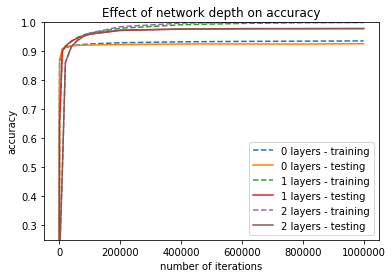

In [ ]:
# plt.plot(iters, [0.7203, 0.86215, 0.9042666666666667, 0.9144666666666666, 0.9204333333333333, 0.9234833333333333, 0.9254], '--', label='0 layers - training')
# plt.plot(iters, [0.7314, 0.8716, 0.9094, 0.9154, 0.9209, 0.9216, 0.9218], '-', label='0 layers - testing')
# plt.plot(iters, [0.16626666666666667, 0.6699, 0.8962, 0.9207666666666666, 0.9423666666666667, 0.9549, 0.9628166666666667], '--', label='1 layers - training')
# plt.plot(iters, [0.1688, 0.669, 0.9002, 0.924, 0.9409, 0.9524, 0.9586], '-', label='1 layers - testing')
# plt.plot(iters, [0.10343333333333334, 0.19181666666666666, 0.4811666666666667, 0.8877666666666667, 0.9297333333333333, 0.9504833333333333, 0.9615166666666667], '--', label='2 layers - training')
# plt.plot(iters, [0.111, 0.2035, 0.4816, 0.8875, 0.9292, 0.948, 0.9569], '-', label='2 layers - testing')

plt.plot(iters, train_accuracy_0, '--', label='0 layers - training')
plt.plot(iters, test_accuracy_0, '-', label='0 layers - testing')
plt.plot(iters, train_accuracy_1, '--', label='1 layers - training')
plt.plot(iters, test_accuracy_1, '-', label='1 layers - testing')
plt.plot(iters, train_accuracy_2, '--', label='2 layers - training')
plt.plot(iters, test_accuracy_2, '-', label='2 layers - testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Effect of network depth on accuracy")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

### Task 3.2:
Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the activations are now sigmoid and tanh. After training these two models compare their test accuracies with model having ReLU activations. Comment on the performances of these models: which one is better and why? Are certain activations better than others? If the results are not as you expected, what could be the reason?

In [ ]:
# MLP with 2 hidden layers having each having 128 units and logistic activations
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=logistic, layers=2, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_3 = []
test_accuracy_3 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_3.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_3.append(y_test_acc)

print("train_accuracy_3: ", train_accuracy_3)
print("test_accuracy_3: ", test_accuracy_3)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_3:  [0.09915, 0.09915, 0.11236666666666667, 0.11236666666666667, 0.11236666666666667, 0.1141, 0.29711666666666664, 0.5825166666666667, 0.7704833333333333, 0.9087, 0.9586666666666667, 0.97575, 0.98515, 0.9906666666666667]
test_accuracy_3:  [0.1009, 0.1009, 0.1135, 0.1135, 0.1135, 0.1156, 0.2931, 0.5831, 0.7722, 0.9072, 0.9533, 0.9648, 0.969, 0.972]


In [ ]:
# MLP with 2 hidden layers having each having 128 units and tanh activations
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=tanh, layers=2, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_4 = []
test_accuracy_4 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_4.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_4.append(y_test_acc)

print("train_accuracy_4: ", train_accuracy_4)
print("test_accuracy_4: ", test_accuracy_4)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_4:  [0.04845, 0.06446666666666667, 0.43206666666666665, 0.7356, 0.8368833333333333, 0.8966166666666666, 0.9150833333333334, 0.92385, 0.9295166666666667, 0.9455833333333333, 0.9569, 0.9598666666666666, 0.9538166666666666, 0.9356666666666666]
test_accuracy_4:  [0.0463, 0.0625, 0.4312, 0.7425, 0.8423, 0.8956, 0.9142, 0.9229, 0.9271, 0.937, 0.9429, 0.9418, 0.9409, 0.9298]


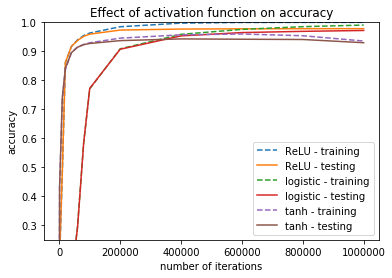

In [ ]:
plt.plot(iters, train_accuracy_2, '--', label='ReLU - training')
plt.plot(iters, test_accuracy_2, '-', label='ReLU - testing')
plt.plot(iters, train_accuracy_3, '--', label='logistic - training')
plt.plot(iters, test_accuracy_3, '-', label='logistic - testing')
plt.plot(iters, train_accuracy_4, '--', label='tanh - training')
plt.plot(iters, test_accuracy_4, '-', label='tanh - testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Effect of activation function on accuracy")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

### Task 3.3:
Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, add L2 regularization (weight decay) to the cost and train the MLP in this way. How does this affect the accuracy?

In [ ]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
# l2_reg = 0.001
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128], l2_reg = 0.001).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_5 = []
test_accuracy_5 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_5.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_5.append(y_test_acc)

print("train_accuracy_5: ", train_accuracy_5)
print("test_accuracy_5: ", test_accuracy_5)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_5:  [0.08675, 0.09205, 0.15856666666666666, 0.5175, 0.8598666666666667, 0.91495, 0.9376666666666666, 0.95235, 0.9608, 0.9811666666666666, 0.99415, 0.9976833333333334, 0.99885, 0.9992166666666666]
test_accuracy_5:  [0.0857, 0.0914, 0.1579, 0.5155, 0.8625, 0.9135, 0.9365, 0.9497, 0.9588, 0.9719, 0.9788, 0.9802, 0.9799, 0.9804]


In [ ]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
# l2_reg = 0.01
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128], l2_reg = 0.01).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_6 = []
test_accuracy_6 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_6.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_6.append(y_test_acc)

print("train_accuracy_6: ", train_accuracy_6)
print("test_accuracy_6: ", test_accuracy_6)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_6:  [0.0583, 0.06403333333333333, 0.16816666666666666, 0.45231666666666664, 0.84545, 0.9073166666666667, 0.9291166666666667, 0.9408, 0.9476166666666667, 0.96295, 0.9707666666666667, 0.97265, 0.9739666666666666, 0.9747833333333333]
test_accuracy_6:  [0.0551, 0.0613, 0.1559, 0.4556, 0.8483, 0.9069, 0.9272, 0.9383, 0.9463, 0.9615, 0.9669, 0.9682, 0.9692, 0.9699]


In [ ]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
# l2_reg = 0.1
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128], l2_reg = 0.1).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_7 = []
test_accuracy_7 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_7.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_7.append(y_test_acc)

print("train_accuracy_7: ", train_accuracy_7)
print("test_accuracy_7: ", test_accuracy_7)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_7:  [0.08273333333333334, 0.0872, 0.1511, 0.30641666666666667, 0.17205, 0.40618333333333334, 0.39555, 0.3902833333333333, 0.6434, 0.8211, 0.8593666666666666, 0.8609166666666667, 0.8643166666666666, 0.8702]
test_accuracy_7:  [0.0895, 0.0953, 0.1637, 0.313, 0.1787, 0.4075, 0.3942, 0.3923, 0.6459, 0.8227, 0.8573, 0.8587, 0.8615, 0.8691]


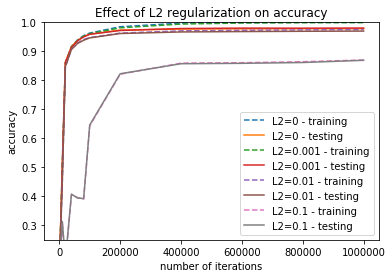

In [ ]:
plt.plot(iters, train_accuracy_2, '--', label='L2=0 - training')
plt.plot(iters, test_accuracy_2, '-', label='L2=0 - testing')
plt.plot(iters, train_accuracy_5, '--', label='L2=0.001 - training')
plt.plot(iters, test_accuracy_5, '-', label='L2=0.001 - testing')
plt.plot(iters, train_accuracy_6, '--', label='L2=0.01 - training')
plt.plot(iters, test_accuracy_6, '-', label='L2=0.01 - testing')
plt.plot(iters, train_accuracy_7, '--', label='L2=0.1 - training')
plt.plot(iters, test_accuracy_7, '-', label='L2=0.1 - testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Effect of L2 regularization on accuracy")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

### Task 3.4:
Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, train it with unnormalized images. How does this affect the accuracy?

In [ ]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec_unnormalized, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_8 = []
test_accuracy_8 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec_unnormalized, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec_unnormalized, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_8.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_8.append(y_test_acc)

print("train_accuracy_8: ", train_accuracy_8)
print("test_accuracy_8: ", test_accuracy_8)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_8:  [0.21588333333333334, 0.73175, 0.9108833333333334, 0.98345, 0.9954166666666666, 0.9998666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
test_accuracy_8:  [0.2215, 0.7411, 0.9167, 0.9737, 0.9767, 0.9764, 0.9767, 0.9771, 0.9773, 0.9779, 0.978, 0.9778, 0.978, 0.9781]


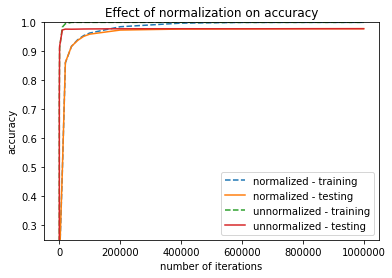

In [ ]:
plt.plot(iters, train_accuracy_2, '--', label='normalized - training')
plt.plot(iters, test_accuracy_2, '-', label='normalized - testing')
plt.plot(iters, train_accuracy_8, '--', label='unnormalized - training')
plt.plot(iters, test_accuracy_8, '-', label='unnormalized - testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Effect of normalization on accuracy")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

## Creativity
The above experiments are the minimum requirements that you must complete; however, this project is open-ended. For example, you might investigate the width (number of units in the hidden layers) of the MLP on its test accuracy. We would also love to see possible the effect of different regularizations on the final performance. Another interesting thing to report might be training the MLP with $10^k, k \in \{0, 1, 2, 3, 4\}$ images and plotting the test accuracy. You do not need to do all of these things, but you should demonstrate creativity, rigour, and an understanding of the course material in how you run your chosen experiments and how you report on them in your write-up.

### Creativity 1:
Investigate the effect of width (number of units in the hidden layers) on test accuracy.

In [ ]:
# MLP with 2 hidden layers having each having 64 units and ReLU activations
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[64, 64]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_9 = []
test_accuracy_9 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_9.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_9.append(y_test_acc)

print("train_accuracy_9: ", train_accuracy_9)
print("test_accuracy_9: ", test_accuracy_9)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_9:  [0.10765, 0.10995, 0.13915, 0.36196666666666666, 0.77385, 0.9007, 0.9265166666666667, 0.9420666666666667, 0.9523333333333334, 0.97785, 0.9940333333333333, 0.9990166666666667, 0.9998166666666667, 0.9999666666666667]
test_accuracy_9:  [0.1079, 0.1107, 0.1398, 0.3574, 0.7819, 0.8987, 0.9227, 0.9375, 0.9492, 0.9683, 0.9729, 0.9746, 0.9741, 0.974]


In [ ]:
# MLP with 2 hidden layers having each having 32 units and ReLU activations
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[32, 32]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_10 = []
test_accuracy_10 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_10.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_10.append(y_test_acc)

print("train_accuracy_10: ", train_accuracy_10)
print("test_accuracy_10: ", test_accuracy_10)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_10:  [0.056666666666666664, 0.0577, 0.07276666666666666, 0.15303333333333333, 0.23011666666666666, 0.8597, 0.9017, 0.922, 0.9376, 0.9684333333333334, 0.9857166666666667, 0.9936166666666667, 0.9978333333333333, 0.9994166666666666]
test_accuracy_10:  [0.0537, 0.0548, 0.0712, 0.1486, 0.2333, 0.8627, 0.8998, 0.9196, 0.9349, 0.9619, 0.9684, 0.9664, 0.9649, 0.9641]


In [ ]:
# MLP with 2 hidden layers having each having 16 units and ReLU activations
optimizer = MBSGD(max_iters=1e6, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[16, 16]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_11 = []
test_accuracy_11 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_11.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_11.append(y_test_acc)

print("train_accuracy_11: ", train_accuracy_11)
print("test_accuracy_11: ", test_accuracy_11)

iteration: 100000
iteration: 200000
iteration: 300000
iteration: 400000
iteration: 500000
iteration: 600000
iteration: 700000
iteration: 800000
iteration: 900000
iteration: 1000000
train_accuracy_11:  [0.08273333333333334, 0.08366666666666667, 0.09505, 0.19045, 0.20233333333333334, 0.6924333333333333, 0.87415, 0.9065666666666666, 0.92465, 0.9567, 0.9707166666666667, 0.9776, 0.9811333333333333, 0.9840833333333333]
test_accuracy_11:  [0.0832, 0.0833, 0.0932, 0.189, 0.2029, 0.6977, 0.8757, 0.9069, 0.9215, 0.9495, 0.9552, 0.9557, 0.955, 0.953]


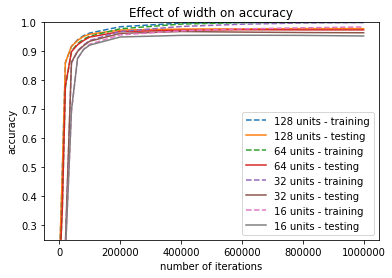

In [ ]:
plt.plot(iters, train_accuracy_2, '--', label='128 units - training')
plt.plot(iters, test_accuracy_2, '-', label='128 units - testing')
plt.plot(iters, train_accuracy_9, '--', label='64 units - training')
plt.plot(iters, test_accuracy_9, '-', label='64 units - testing')
plt.plot(iters, train_accuracy_10, '--', label='32 units - training')
plt.plot(iters, test_accuracy_10, '-', label='32 units - testing')
plt.plot(iters, train_accuracy_11, '--', label='16 units - training')
plt.plot(iters, test_accuracy_11, '-', label='16 units - testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Effect of width on accuracy")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

### Creativity 2:
Train the MLP with $10^k, k \in \{0, 1, 2, 3\}$ images and plot the test accuracy.

In [11]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
# 10^0 images
size = pow(10,0)
optimizer = MBSGD(max_iters=1e5, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec[:size], MNIST_y_train[:size], optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_12 = []
test_accuracy_12 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_12.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_12.append(y_test_acc)

print("train_accuracy_12: ", train_accuracy_12)
print("test_accuracy_12: ", test_accuracy_12)

iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_12:  [0.1011, 0.09713333333333334, 0.09035, 0.09035, 0.09035, 0.09035, 0.09035, 0.09035, 0.09035]
test_accuracy_12:  [0.0984, 0.0981, 0.0892, 0.0892, 0.0892, 0.0892, 0.0892, 0.0892, 0.0892]


In [13]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
# 10^1 images
size = pow(10,1)
optimizer = MBSGD(max_iters=1e5, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec[:size], MNIST_y_train[:size], optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_13 = []
test_accuracy_13 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_13.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_13.append(y_test_acc)

print("train_accuracy_13: ", train_accuracy_13)
print("test_accuracy_13: ", test_accuracy_13)

iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_13:  [0.09918333333333333, 0.11448333333333334, 0.20648333333333332, 0.3892333333333333, 0.39358333333333334, 0.3959, 0.39705, 0.3978833333333333, 0.39815]
test_accuracy_13:  [0.0991, 0.1176, 0.2057, 0.3895, 0.3938, 0.3958, 0.3968, 0.3974, 0.3979]


In [14]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
# 10^2 images
size = pow(10,2)
optimizer = MBSGD(max_iters=1e5, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec[:size], MNIST_y_train[:size], optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_14 = []
test_accuracy_14 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_14.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_14.append(y_test_acc)

print("train_accuracy_14: ", train_accuracy_14)
print("test_accuracy_14: ", test_accuracy_14)

iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_14:  [0.08318333333333333, 0.08908333333333333, 0.2477, 0.5749166666666666, 0.5918666666666667, 0.59435, 0.5950333333333333, 0.5949833333333333, 0.59485]
test_accuracy_14:  [0.0849, 0.0901, 0.249, 0.5639, 0.5751, 0.5779, 0.5778, 0.5794, 0.581]


In [15]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
# 10^3 images
size = pow(10,3)
optimizer = MBSGD(max_iters=1e5, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec[:size], MNIST_y_train[:size], optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_15 = []
test_accuracy_15 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_15.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_15.append(y_test_acc)

print("train_accuracy_15: ", train_accuracy_15)
print("test_accuracy_15: ", test_accuracy_15)

iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_15:  [0.08568333333333333, 0.09395, 0.23496666666666666, 0.4752166666666667, 0.81485, 0.8379833333333333, 0.8399, 0.8406, 0.8413833333333334]
test_accuracy_15:  [0.0922, 0.0989, 0.2379, 0.4729, 0.8167, 0.8385, 0.8402, 0.8416, 0.8419]


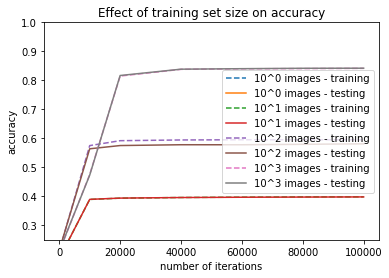

In [16]:
plt.plot(iters, train_accuracy_12, '--', label='10^0 images - training')
plt.plot(iters, test_accuracy_12, '-', label='10^0 images - testing')
plt.plot(iters, train_accuracy_13, '--', label='10^1 images - training')
plt.plot(iters, test_accuracy_13, '-', label='10^1 images - testing')
plt.plot(iters, train_accuracy_14, '--', label='10^2 images - training')
plt.plot(iters, test_accuracy_14, '-', label='10^2 images - testing')
plt.plot(iters, train_accuracy_15, '--', label='10^3 images - training')
plt.plot(iters, test_accuracy_15, '-', label='10^3 images - testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Effect of training set size on accuracy")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

### Creativity 3:
Implementing Adam Optimizer

In [37]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.99, eps=1e-8, batch_size=48, max_iters=1e4 ,verbose=False, record_history=False):
      self.beta1=beta1
      self.beta2=beta2
      self.eps=eps
      self.learning_rate = learning_rate
      self.mean = 0
      self.var = 0
      self.batch_size = batch_size
      self.max_iters=max_iters
      self.verbose=verbose
      self.record_history=record_history
      if self.record_history:
        self.record_iters = []
        self.record_params = []

    def get_minibatches(self, x, y, batch_size):
        minibatches = []
        x, y = shuffle(x,y)
        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            minibatches.append((x_batch, y_batch))
        return minibatches

    def update(self, w, dw, t):
      # momentum beta1
      self.mean = np.multiply(self.beta1, self.mean) +  np.multiply(dw, (1-self.beta1))
      # rms beta2
      self.var = np.multiply(self.beta2, self.var) + np.multiply((1-self.beta2) , np.square(dw))

      mean_corr = np.divide(self.mean, (1-self.beta1**t))
      var_corr = np.divide(self.var , (1-self.beta2**t))

      out = [None for _ in range(len(w))]
      for i in range(len(w)):
        u = w[i] - np.multiply(self.learning_rate, (np.divide( mean_corr[i], (np.sqrt(var_corr[i])+self.eps))))
        out[i] = u
      return out

    def run(self, gradient_fn, x, y, params):
        minibatches = self.get_minibatches(x,y,self.batch_size)
        norms = np.array([np.inf])
        params0 = params
        t = 1
        i = 0
        adam_iters = [1, 10, 100, 1000, 10000, 20000, 40000, 60000, 80000, 100000, 200000, 400000, 600000, 800000, 1000000]
        while np.any(norms > self.eps) and t < self.max_iters:
            curr_x, curr_y = minibatches[i]
            grad = gradient_fn(curr_x, curr_y, params)
            params0 = params
            params = self.update(params0, grad, t)
            
            
            norms = np.array([np.linalg.norm(g) for g in grad])
            if np.any(norms < self.eps):
              print('convergenced reached at {} iters ', t)

            # finished epoch when i == len(minibatches)
            # shuffle minibatches again so that you always have different minibatches
            if (t in adam_iters) and self.record_history:
                print('appended {} iters ', t)
                copy_params = copy.deepcopy(params)
                self.record_params.append(copy_params)
                self.record_iters.append(t)
            t += 1
            i += 1
            if (i == len(minibatches)):
                i = 0
                minibatches = self.get_minibatches(x,y,self.batch_size)
            if (t % (self.max_iters/10) == 0) and self.verbose:
                print("iteration:", t)
          
        return params

In [38]:
import time

# RUN ADAM
for i in range(2, 4):
  for depth in range(0,3):
    adam = Adam(max_iters=(10**i), batch_size=128)
    model = MLP(layers=depth, activation_fn=relu, M=[128,128]).fit(MNIST_x_train_vec, MNIST_y_train, adam)
    y_pred = model.predict(MNIST_x_test_vec)
    y_pred = np.argmax(y_pred, axis=1)
    acc = evaluate_acc(y_pred, MNIST_y_test)
    print("{} achieved with {} hidden layers and 1e{} iterations".format(acc, depth, i))

0.8909 achieved with 0 hidden layers and 1e2 iterations


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.9018 achieved with 1 hidden layers and 1e2 iterations
0.8836 achieved with 2 hidden layers and 1e2 iterations
0.9214 achieved with 0 hidden layers and 1e3 iterations
0.9652 achieved with 1 hidden layers and 1e3 iterations
0.9633 achieved with 2 hidden layers and 1e3 iterations


In [39]:
optimizer = Adam(learning_rate=0.001, max_iters=1e5, batch_size=96, verbose=False, eps=1e-8, record_history=True) 

# MLP with 2 hidden layers having each having 128 units and ReLU activations
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_adam = []
test_accuracy_adam = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_adam.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_adam.append(y_test_acc)

print("train_accuracy_adam: ", train_accuracy_adam)
print("test_accuracy_adam: ", test_accuracy_adam)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


appended {} iters  1
appended {} iters  10
appended {} iters  100
appended {} iters  1000
appended {} iters  10000
appended {} iters  20000
convergenced reached at {} iters  36426
train_accuracy_adam:  [0.2692833333333333, 0.48733333333333334, 0.8697333333333334, 0.9703, 0.9947166666666667, 0.9968833333333333]
test_accuracy_adam:  [0.2766, 0.4912, 0.8691, 0.9643, 0.9767, 0.9785]


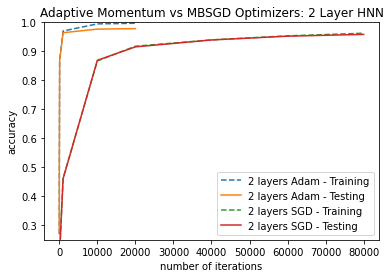

In [40]:
graph_iters = [1, 10, 100, 1000, 10000, 20000, 40000, 60000, 80000, 100000, 200000, 400000, 600000, 800000, 1000000]
graph_iters = graph_iters[:9]
plt.plot(graph_iters[:6], train_accuracy_adam, '--', label='2 layers Adam - Training')
plt.plot(graph_iters[:6], test_accuracy_adam, '-', label='2 layers Adam - Testing')
plt.plot(graph_iters[:9], train_accuracy_2, '--', label='2 layers SGD - Training')
plt.plot(graph_iters[:9], test_accuracy_2, '-', label='2 layers SGD - Testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Adaptive Momentum vs MBSGD Optimizers: 2 Layer HNN")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

In [43]:
optimizer = Adam(learning_rate=0.001, max_iters=1e5, batch_size=96, verbose=False, eps=1e-8, record_history=True) 

# 1 Layer Model
model = MLP(activation_fn=relu, layers=1, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_adam_1 = []
test_accuracy_adam_1 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_adam_1.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_adam_1.append(y_test_acc)

print("train_accuracy_adam: ", train_accuracy_adam_1)
print("test_accuracy_adam: ", test_accuracy_adam_1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


appended {} iters  1
appended {} iters  10
appended {} iters  100
appended {} iters  1000
appended {} iters  10000
appended {} iters  20000
appended {} iters  40000
convergenced reached at {} iters  49168
train_accuracy_adam:  [0.34753333333333336, 0.6050666666666666, 0.8896666666666667, 0.9663666666666667, 0.9985833333333334, 0.9984666666666666, 0.9996333333333334]
test_accuracy_adam:  [0.3541, 0.6253, 0.8922, 0.9657, 0.9777, 0.9765, 0.9782]


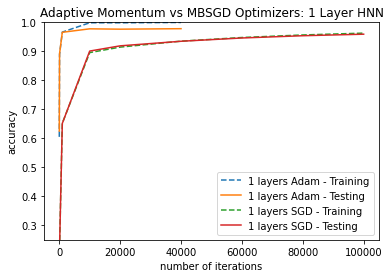

In [44]:
graph_iters = [10, 100, 1000, 10000, 20000, 40000, 60000, 80000, 100000, 200000, 400000, 600000, 800000, 1000000]
l = len(train_accuracy_adam_1)
plt.plot(graph_iters[:l-1], train_accuracy_adam_1[1:], '--', label='1 layers Adam - Training')
plt.plot(graph_iters[:l-1], test_accuracy_adam_1[1:], '-', label='1 layers Adam - Testing')
plt.plot(graph_iters[:9], train_accuracy_1, '--', label='1 layers SGD - Training')
plt.plot(graph_iters[:9], test_accuracy_1, '-', label='1 layers SGD - Testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Adaptive Momentum vs MBSGD Optimizers: 1 Layer HNN")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

In [45]:
optimizer = Adam(learning_rate=0.001, max_iters=1e5, batch_size=96, verbose=False, eps=1e-8, record_history=True) 

# No Layer Model
model = MLP(activation_fn=relu, layers=0, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_adam_0 = []
test_accuracy_adam_0 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_adam_0.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_adam_0.append(y_test_acc)

print("train_accuracy_adam: ", train_accuracy_adam_0)
print("test_accuracy_adam: ", test_accuracy_adam_0)

appended {} iters  1
appended {} iters  10
appended {} iters  100
appended {} iters  1000
appended {} iters  10000
appended {} iters  20000
appended {} iters  40000
appended {} iters  60000
appended {} iters  80000
train_accuracy_adam:  [0.25876666666666664, 0.7302833333333333, 0.8831, 0.91925, 0.9336833333333333, 0.9346166666666667, 0.9363166666666667, 0.93845, 0.9355833333333333]
test_accuracy_adam:  [0.2554, 0.744, 0.8904, 0.92, 0.9251, 0.9235, 0.9217, 0.924, 0.9201]


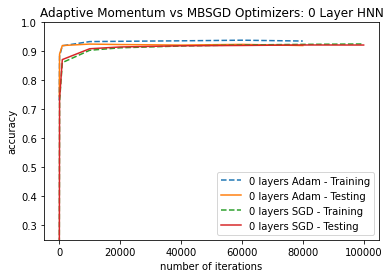

In [46]:
l = len(train_accuracy_0)
plt.plot(graph_iters[:l-1], train_accuracy_adam_0[1:], '--', label='0 layers Adam - Training')
plt.plot(graph_iters[:l-1], test_accuracy_adam_0[1:], '-', label='0 layers Adam - Testing')
plt.plot(graph_iters[:9], train_accuracy_0, '--', label='0 layers SGD - Training')
plt.plot(graph_iters[:9], test_accuracy_0, '-', label='0 layers SGD - Testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Adaptive Momentum vs MBSGD Optimizers: 0 Layer HNN")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()

### Creativity 4:
Impact of learning rate on the accuracy performance

iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_16:  [0.14215, 0.14296666666666666, 0.15253333333333333, 0.24986666666666665, 0.34346666666666664, 0.3966166666666667, 0.29985, 0.3192833333333333, 0.5579333333333333]
test_accuracy_16:  [0.142, 0.143, 0.1534, 0.2505, 0.3434, 0.3917, 0.2975, 0.3236, 0.5631]
iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iteration: 80000
iteration: 90000
iteration: 100000
train_accuracy_17:  [0.10841666666666666, 0.12146666666666667, 0.2394, 0.44565, 0.86055, 0.9169166666666667, 0.9394166666666667, 0.9525666666666667, 0.9618166666666667]
test_accuracy_17:  [0.1172, 0.1297, 0.2454, 0.44, 0.8621, 0.9166, 0.9403, 0.9498, 0.9572]
iteration: 10000
iteration: 20000
iteration: 30000
iteration: 40000
iteration: 50000
iteration: 60000
iteration: 70000
iterati

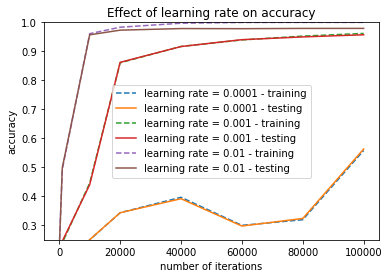

In [47]:
# MLP with 2 hidden layers having each having 128 units and ReLU activations
# learning_rate = 0.0001
optimizer = MBSGD(learning_rate=0.0001, max_iters=1e5, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_16 = []
test_accuracy_16 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_16.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_16.append(y_test_acc)

print("train_accuracy_16: ", train_accuracy_16)
print("test_accuracy_16: ", test_accuracy_16)

# MLP with 2 hidden layers having each having 128 units and ReLU activations
# learning_rate = 0.001
optimizer = MBSGD(learning_rate=0.001, max_iters=1e5, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_17 = []
test_accuracy_17 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_17.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_17.append(y_test_acc)

print("train_accuracy_17: ", train_accuracy_17)
print("test_accuracy_17: ", test_accuracy_17)

# MLP with 2 hidden layers having each having 128 units and ReLU activations
# learning_rate = 0.01
optimizer = MBSGD(learning_rate=0.01, max_iters=1e5, verbose=True, record_history=True) # train 1e6 overnight
model = MLP(activation_fn=relu, layers=2, M=[128, 128]).fit(MNIST_x_train_vec, MNIST_y_train, optimizer)
params = optimizer.record_params
iters = optimizer.record_iters
train_accuracy_18 = []
test_accuracy_18 = []

for i in range(len(params)):
    y_train = model.predict_wp(MNIST_x_train_vec, params[i])
    y_train = np.argmax(y_train, axis=1)

    y_test = model.predict_wp(MNIST_x_test_vec, params[i])
    y_test = np.argmax(y_test, axis=1)

    y_train_acc = evaluate_acc(y_train, MNIST_y_train_original)
    train_accuracy_18.append(y_train_acc)

    y_test_acc = evaluate_acc(y_test, MNIST_y_test)
    test_accuracy_18.append(y_test_acc)

print("train_accuracy_18: ", train_accuracy_18)
print("test_accuracy_18: ", test_accuracy_18)

plt.plot(iters, train_accuracy_16, '--', label='learning rate = 0.0001 - training')
plt.plot(iters, test_accuracy_16, '-', label='learning rate = 0.0001 - testing')
plt.plot(iters, train_accuracy_17, '--', label='learning rate = 0.001 - training')
plt.plot(iters, test_accuracy_17, '-', label='learning rate = 0.001 - testing')
plt.plot(iters, train_accuracy_18, '--', label='learning rate = 0.01 - training')
plt.plot(iters, test_accuracy_18, '-', label='learning rate = 0.01 - testing')

plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.title("Effect of learning rate on accuracy")
plt.legend()
plt.ylim(0.25, 1.0)
plt.show()